In [7]:
pip install --upgrade tensorflow==2.15.0

Note: you may need to restart the kernel to use updated packages.


In [8]:
!pip install opencv-python==4.5.4.58

  Using cached opencv_python-4.5.4.58-cp310-cp310-manylinux2014_x86_64.whl.metadata (18 kB)
Using cached opencv_python-4.5.4.58-cp310-cp310-manylinux2014_x86_64.whl (60.3 MB)
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.9.0.80
    Uninstalling opencv-python-4.9.0.80:
      Successfully uninstalled opencv-python-4.9.0.80
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.4.0 requires opencv-python>=4.9.0, but you have opencv-python 4.5.4.58 which is incompatible.
ultralytics 8.1.37 requires opencv-python>=4.6.0, but you have opencv-python 4.5.4.58 which is incompatible.


In [9]:
!pip install -q ultralytics
import ultralytics
from ultralytics import YOLO
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import wandb
wandb.init(mode="disabled")
import shutil

In [10]:
data_folder = "/kaggle/input/brain-tumor-object-detection-datasets"
output_folder = 'braintumors'
data_folder_yolo = output_folder + "_yolo"
data_folder_coco = output_folder + "_coco"
folders = os.listdir(data_folder)
print(folders)

['coronal_t1wce_2_class', 'axial_t1wce_2_class', 'sagittal_t1wce_2_class']


In [11]:
from glob import glob
def count_yolo_data(folder):
    for images_labels in ['images', 'labels']:
        for train_test in ['train', 'test']:
            file_ext = '*.jpg' if images_labels == 'images' else '*.txt'
            p = os.path.join(folder, images_labels, train_test, file_ext)
            files = glob(p)
            print(train_test, images_labels, len(files))

In [12]:
for folder in folders:
    print('-'*8 + folder + '-'*8)
    folder = os.path.join(data_folder, folder)
    count_yolo_data(folder)

--------coronal_t1wce_2_class--------
train images 319
test images 78
train labels 318
test labels 78
--------axial_t1wce_2_class--------
train images 310
test images 75
train labels 296
test labels 75
--------sagittal_t1wce_2_class--------
train images 264
test images 70
train labels 264
test labels 70


In [13]:
import shutil
from tqdm import tqdm
# move all into one folder
def copy_yolo_files(from_folder, to_folder, images_labels, train_test):
    from_path = os.path.join(from_folder, images_labels, train_test)
    to_path = os.path.join(to_folder, images_labels, train_test)
    os.makedirs(to_path, exist_ok = True)

    # Get the list of all label files in the labels directory for the given train/test split
    label_from_path = os.path.join(from_folder, "labels", train_test)
    label_files = glob(os.path.join(label_from_path, "*.txt"))
    label_file_names = [os.path.basename(f) for f in label_files]

    # Get the list of all image files in the images directory for the given train/test split
    file_ext = "*.jpg" if images_labels == "images" else "*.txt"
    files = glob(os.path.join(from_path, file_ext))

    # Move files that have a corresponding label file
    for file in tqdm(files):
        file_name = os.path.basename(file)
        if file_name.split('.')[0] + '.txt' in label_file_names:
            shutil.copy(file, to_path)

In [14]:
# copy
for from_folder in folders:
    from_folder = os.path.join(data_folder, from_folder)
    to_folder = data_folder_yolo
    for images_labels in ['images', 'labels']:
        for train_test in ['train', 'test']:
            copy_yolo_files(from_folder, to_folder, images_labels, train_test)

100%|██████████| 70/70 [00:00<00:00, 244.24it/s]


In [15]:
!tree -d {data_folder_yolo}

braintumors_yolo
|-- images
|   |-- test
|   `-- train
`-- labels
    |-- test
    `-- train

6 directories


In [16]:
# read the yaml file and write the class file
import yaml
from yaml.loader import SafeLoader

# Open the file and load the file
with open(os.path.join(data_folder, folders[0], folders[0]+'.yaml')) as f:
      classes = yaml.load(f, Loader=SafeLoader)["names"]
# Write classes.txt
with open(os.path.join(data_folder_yolo, "classes.txt"), "w") as f:
      f.write('\n'.join(classes))

In [17]:
def count_data_move(folder):
    for images_labels in ['images', 'labels']:
        for train_test in ['train', 'test']:
            subfolder = os.path.join(folder, images_labels, train_test)
            num_files = len(os.listdir(subfolder))
            print(f'Number of files in {images_labels}/{train_test}: {num_files}')

count_data_move('braintumors_yolo')

Number of files in images/train: 878
Number of files in images/test: 223
Number of files in labels/train: 878
Number of files in labels/test: 223


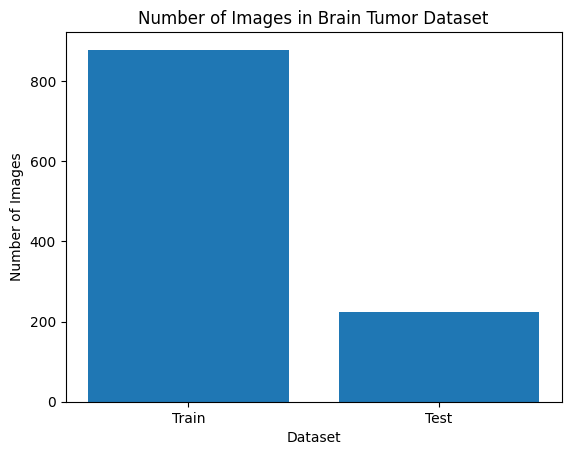

In [18]:
train_data_dir = os.path.join('/kaggle/working/braintumors_yolo', 'images', 'train')
test_data_dir = os.path.join('/kaggle/working/braintumors_yolo', 'images', 'test')

# Get a list of all the image files in the training and test data directories.
train_image_files = glob(os.path.join(train_data_dir, '*.jpg'))
test_image_files = glob(os.path.join(test_data_dir, '*.jpg'))

# Count the number of image files in the training and test data directories.
num_train_images = len(train_image_files)
num_test_images = len(test_image_files)

# Plot the number of training and test images.
plt.bar(['Train', 'Test'], [num_train_images, num_test_images])
plt.title('Number of Images in Brain Tumor Dataset')
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.show()

# Phần R-CNN

if os.path.exists('dataset'):
    shutil.rmtree('dataset')
shutil.copytree('/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class', 'dataset')

In [19]:
# Đọc file và in ảnh bất kỳ
files = os.listdir('braintumors_yolo/images/train')
random_file = random.choice(files)
random_file = os.path.splitext(random_file)[0]
print(random_file)

00240_134


(256, 192, 3)


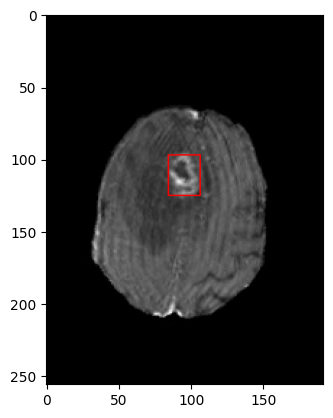

In [20]:
with open(os.path.join('braintumors_yolo/labels/train', f'{random_file}.txt'),'r') as f:
    labels = f.readlines()
    labels = labels[0].split(' ')
    f.close()

# Giá trị 1 là đọc ảnh màu, 0 là ảnh xám
img = cv2.imread(os.path.join('braintumors_yolo/images/train', f'{random_file}.jpg'), 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Tập labels chứa các file .txt. Lưu các giá trị về label, tọa độ, kích thước khung
# Toạ độ được lưu là toạ độ tâm của khung ảnh
# Gồm 5 giá trị: giá trị đầu tiên là label (0, 1), giá trị thứ 2 là tọa độ x, giá trị thứ 3 là tọa độ y
# Giá trị thứ 4 là chiều rộng và cuối cùng là chiều cao của khung. Tất cả được phân tách bằng dấu cách
tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
x_pt1 = int((x - w/2) * img.shape[1])
y_pt1 = int((y - h/2) * img.shape[0])
x_pt2 = int((x + w/2) * img.shape[1])
y_pt2 = int((y + h/2) * img.shape[0])

if tumor_class == 1:
    colour = (255, 0, 0)
else:
    colour = (0, 255, 0)
cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)

print(img.shape)
plt.imshow(img)

# Load và kiểm tra dữ liệu

In [21]:
train_images = os.listdir('braintumors_yolo/images/train')
test_images = os.listdir('braintumors_yolo/images/test')
train_labels = os.listdir('braintumors_yolo/labels/train')
test_labels = os.listdir('braintumors_yolo/labels/test')

num_train_images = len(train_images)
num_test_images = len(test_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)

print(num_train_images, num_test_images)
print(num_train_labels, num_test_labels)

878 223
878 223


### Xử lý dữ liệu

In [22]:
os.path.splitext(random_file)[0]

# Tập set sẽ tạo ra 1 tập hợp các phần tử không trùng lặp, không tuần tự và không có thứ tự cụ thể
# Nó trả về một tập hợp chỉ chứa các phần tử duy nhất từ đối tượng đó.
# Vì thế đoạn code bên dưới sẽ là loại bỏ tất cả các file labels có tên giống với nó trong tập train
unlabelled = set(train_images) - set([os.path.splitext(file)[0] + '.jpg' for file in train_labels])

for image in unlabelled:
    os.remove(os.path.join('braintumors_yolo/images/train', image))

In [23]:
train_images = os.listdir('braintumors_yolo/images/train')
test_images = os.listdir('braintumors_yolo/images/test')
train_labels = os.listdir('braintumors_yolo/labels/train')
test_labels = os.listdir('braintumors_yolo/labels/test')

num_train_images = len(train_images)
num_test_images = len(test_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)

print(num_train_images, num_test_images)
print(num_train_labels, num_test_labels)

878 223
878 223


### Resize ảnh và khung label

In [24]:
WIDTH = 256
HEIGHT = 256

In [25]:
with open(os.path.join('braintumors_yolo/labels/'+ 'train', f'{os.path.splitext(train_images[0])[0]}.txt'),'r') as f:
    label = f.readlines()
    label = label[0].split(' ')
    f.close()
print(label)

['1', '0.536972', '0.410798', '0.109155', '0.115023']


246 180 302 239
(512, 512, 3)


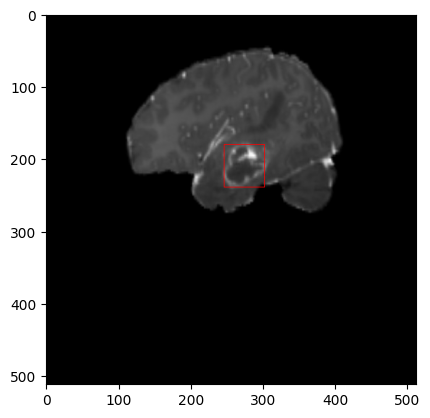

In [26]:
img = cv2.imread(os.path.join('braintumors_yolo/images/train', f'{os.path.splitext(train_images[0])[0]}.jpg'), 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Tập labels chứa các file .txt. Lưu các giá trị về label, tọa độ, kích thước khung
# Gồm 5 giá trị: giá trị đầu tiên là label (0, 1), giá trị thứ 2 là tọa độ x, giá trị thứ 3 là tọa độ y
# Giá trị thứ 4 là toạ độ x của góc phải dưới và cuối cùng là toạ độ y của góc phải dưới. Tất cả được phân tách bằng dấu cách
tumor_class, x, y, w, h = int(label[0]), float(label[1]), float(label[2]), float(label[3]), float(label[4])
x_pt1 = int((x - w/2) * img.shape[1])
y_pt1 = int((y - h/2) * img.shape[0])
x_pt2 = int((x + w/2) * img.shape[1])
y_pt2 = int((y + h/2) * img.shape[0])
print(x_pt1, y_pt1, x_pt2, y_pt2)
if tumor_class == 1:
    colour = (255, 0, 0)
else:
    colour = (0, 255, 0)
cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)

print(img.shape)
plt.imshow(img)

In [27]:
def resize_images_labels(folder_name, files):
    images = []
    labels_tam = []
    bbox_arr = []
    for index in range(len(files)):
        name = os.path.splitext(files[index])[0]
        try:
            image = cv2.imread('braintumors_yolo/images/'+ folder_name +'/'+ name + '.jpg')
            old_height, old_width,_ = image.shape

            # Resize ảnh về kích thước 256x256x3
            image = cv2.resize(image, (WIDTH, HEIGHT))

            # Chuyển đổi ảnh thành mảng numpy
            image_array = np.array(image, dtype=np.uint8)

            if image_array.shape == (WIDTH, HEIGHT, 3) and isinstance(image_array, np.ndarray):
                  # Thêm ảnh vào danh sách
                images.append(image_array)
            else:
                print(f"Ignored image at {files[index]}: Invalid shape {image_array.shape}")
        except Exception as e:
            print(f"Error reading image at {files[index]}: {e}")
            
        with open(os.path.join('braintumors_yolo/labels/'+ folder_name, f'{name}.txt'),'r') as f:
            label = f.readlines()
            label = label[0].split(' ')
            f.close()
        labels_tam.append(int(label[0]))
        bbox = []
        for i in range(1,len(label)):
            bbox.append(float(label[i]))
        bbox_arr.append(bbox)
        
    return np.array(images), np.array(labels_tam), np.array(bbox_arr)

In [28]:
images_train, labels_train, bbox_train = resize_images_labels('train', train_images)
images_test, labels_test, bbox_test = resize_images_labels('test', test_images)

In [29]:
# Chuyển sang dạng one-hot encoding
labels_train = np.eye(2)[labels_train.astype(int)]
# Chuyển sang dạng one-hot encoding
labels_test = np.eye(2)[labels_test.astype(int)]

123 90 151 119
(256, 256, 3)


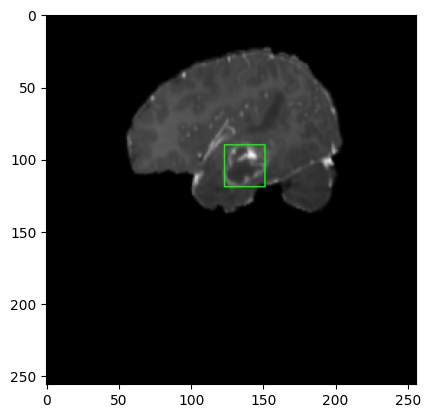

In [30]:
'''
with open(os.path.join('braintumors_yolo/labels/train', f'00097_124.txt'),'r') as f:
    labels = f.readlines()
    labels = labels[0].split(' ')
    f.close()
'''
# Giá trị 1 là đọc ảnh màu, 0 là ảnh xám
img = images_train[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
labels = labels_train[0]
bbox = bbox_train[0]
# Tập labels chứa các file .txt. Lưu các giá trị về label, tọa độ, kích thước khung
# Gồm 5 giá trị: giá trị đầu tiên là label (0, 1), giá trị thứ 2 là tọa độ x, giá trị thứ 3 là tọa độ y
# Giá trị thứ 4 là toạ độ x của góc phải dưới và cuối cùng là toạ độ y của góc phải dưới. Tất cả được phân tách bằng dấu cách
tumor_class, x, y, w, h = int(labels[0]), float(bbox[0]), float(bbox[1]), float(bbox[2]), float(bbox[3])
x_pt1 = int((x - w/2) * img.shape[1])
y_pt1 = int((y - h/2) * img.shape[0])
x_pt2 = int((x + w/2) * img.shape[1])
y_pt2 = int((y + h/2) * img.shape[0])
print(x_pt1, y_pt1, x_pt2, y_pt2)
if tumor_class == 1:
    colour = (255, 0, 0)
else:
    colour = (0, 255, 0)
cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)

print(img.shape)
plt.imshow(img)

val_split = int(num_train_images * 0.2)
val_images = random.sample(train_images, val_split)

if os.path.exists('braintumors_yolo/images/val'):
    shutil.rmtree('braintumors_yolo/images/val')
if os.path.exists('braintumors_yolo/labels/val'):
    shutil.rmtree('braintumors_yolo/labels/val')

os.mkdir('./braintumors_yolo/images/val')
os.mkdir('./braintumors_yolo/labels/val')

for image in val_images:
    shutil.move(os.path.join('braintumors_yolo/images/train', image), 'braintumors_yolo/images/val')

for image in val_images:
    label = os.path.splitext(image)[0] + '.txt'
    shutil.move(os.path.join('braintumors_yolo/labels/train', label), 'braintumors_yolo/labels/val')

images_val = np.array(os.listdir('braintumors_yolo/images/val'))
labels_val = np.array(os.listdir('braintumors_yolo/labels/train'))

# Segmentation image

def get_regions(image):
    # Chuyển ảnh sang định dạng RGB (nếu ảnh không phải là RGB)
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    elif len(image.shape) == 4:
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGB)
    
    # Khởi tạo Selective Search
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    
    # Thêm ảnh vào Selective Search
    ss.setBaseImage(image)
    
    # Thiết lập phương pháp tìm kiếm
    ss.switchToSelectiveSearchQuality()
    
    # Thực hiện tìm kiếm các vùng đề xuất
    rects = ss.process()
    
    # Chọn ra top k vùng đề xuất
    num_regions = 2000
    rects = rects[:num_regions]
    
    # Chuyển định dạng của các bounding box từ (x_trái, y_trái, w, h) sang (x1, y1, x2, y2)
    proposals = []
    for (x, y, w, h) in rects:
        proposals.append([x+w/2, y-h/2, w, h])
    
    return proposals

label_segment = []
for i in images_train:
    label_seg=get_regions(i)
    label_segment.append(label_seg)
np.array(label_segment)

cv2.__version__

print(len(images_train))
print(len(label_segment))

def process_images(annot_path, image_path):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    images = []
    labels = []

    for e, annot_file in enumerate(os.listdir(annot_path)):
        try:
            filename = annot_file.split(".")[0] + ".jpg"
            print(e, filename)
            image = cv2.imread(os.path.join(image_path, filename))

            # Đọc label từ tệp văn bản
            with open(os.path.join(annot_path, annot_file), 'r') as f:
                label_data = f.readline().split()

            gtvalues = []
            x1 = int(float(label_data[1]) * image.shape[1])
            y1 = int(float(label_data[2]) * image.shape[0])
            width = int(float(label_data[3]) * image.shape[1])
            height = int(float(label_data[4]) * image.shape[0])
            x2 = x1 + width
            y2 = y1 + height
            gtvalues.append({"x1": x1, "x2": x2, "y1": y1, "y2": y2})

            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e, result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x, y, w, h = result
                        iou = get_iou(gtval, {"x1": x, "x2": x+w, "y1": y, "y2": y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h, x:x+w]
                                resized = cv2.resize(timage, (224, 224), interpolation=cv2.INTER_AREA)
                                images.append(resized)
                                labels.append(1)
                                counter += 1
                        else:
                            fflag = 1
                        if falsecounter < 30:
                            if iou < 0.3:
                                timage = imout[y:y+h, x:x+w]
                                resized = cv2.resize(timage, (224, 224), interpolation=cv2.INTER_AREA)
                                images.append(resized)
                                labels.append(0)
                                falsecounter += 1
                        else:
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
        except Exception as e:
            print(e)
            print("error in " + filename)
            continue

    return images, labels

# Khởi tạo model

In [40]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

# Xây dựng mô hình R-CNN
def build_rcnn_model(input_shape, num_classes):
    input_img = Input(shape=input_shape)
    
    # Phần CNN
    x = Conv2D(32, (3, 3), padding='same')(input_img)
    x = LeakyReLU(alpha=-0.5)(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=-0.5)(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=-0.5)(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=-0.5)(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=-0.5)(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=-0.5)(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Flatten()(x)
    
    # Phần Fully Connected Layer
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    
    # Đầu ra phân loại
    classification_output = Dense(num_classes, activation='softmax', name='classification')(x)
    
    # Đầu ra dự đoán vị trí đối tượng
    # Vị trí sẽ được dự đoán bằng cách sử dụng một lớp Dense với số lượng đầu ra là 4
    # 4 là vì chúng ta đang dự đoán tọa độ bounding box của đối tượng
    bbox_output = Dense(4, name='bounding_box')(x)
    
    model = Model(inputs=input_img, outputs=[classification_output, bbox_output])
    return model

# Kích thước ảnh và số lớp đầu ra
input_shape = (256, 256, 3)
num_classes = 2

# Xây dựng mô hình
model = build_rcnn_model(input_shape, num_classes)

# Thiết lập learning rate
learning_rate = 0.001  # Đặt learning rate tùy ý

# Tạo optimizer và cấu hình learning rate
optimizer = Adam(learning_rate=learning_rate)

# Biên dịch mô hình với hàm loss và optimizer
model.compile(optimizer=optimizer, 
              loss={'classification': 'categorical_crossentropy', 'bounding_box': MeanSquaredError()},
              metrics={'classification': 'accuracy'})

# In tổng quan của mô hình
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 256, 256, 32)         896       ['input_2[0][0]']             
                                                                                                  
 leaky_re_lu_6 (LeakyReLU)   (None, 256, 256, 32)         0         ['conv2d_6[0][0]']            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 256, 256, 32)         9248      ['leaky_re_lu_6[0][0]']       
                                                                                            

In [33]:
print(images_train.shape)
print(labels_train.shape)
print(bbox_train.shape)
print(images_test.shape)
print(labels_test.shape)
print(bbox_test.shape)

(878, 256, 256, 3)
(878, 2)
(878, 4)
(223, 256, 256, 3)
(223, 2)
(223, 4)


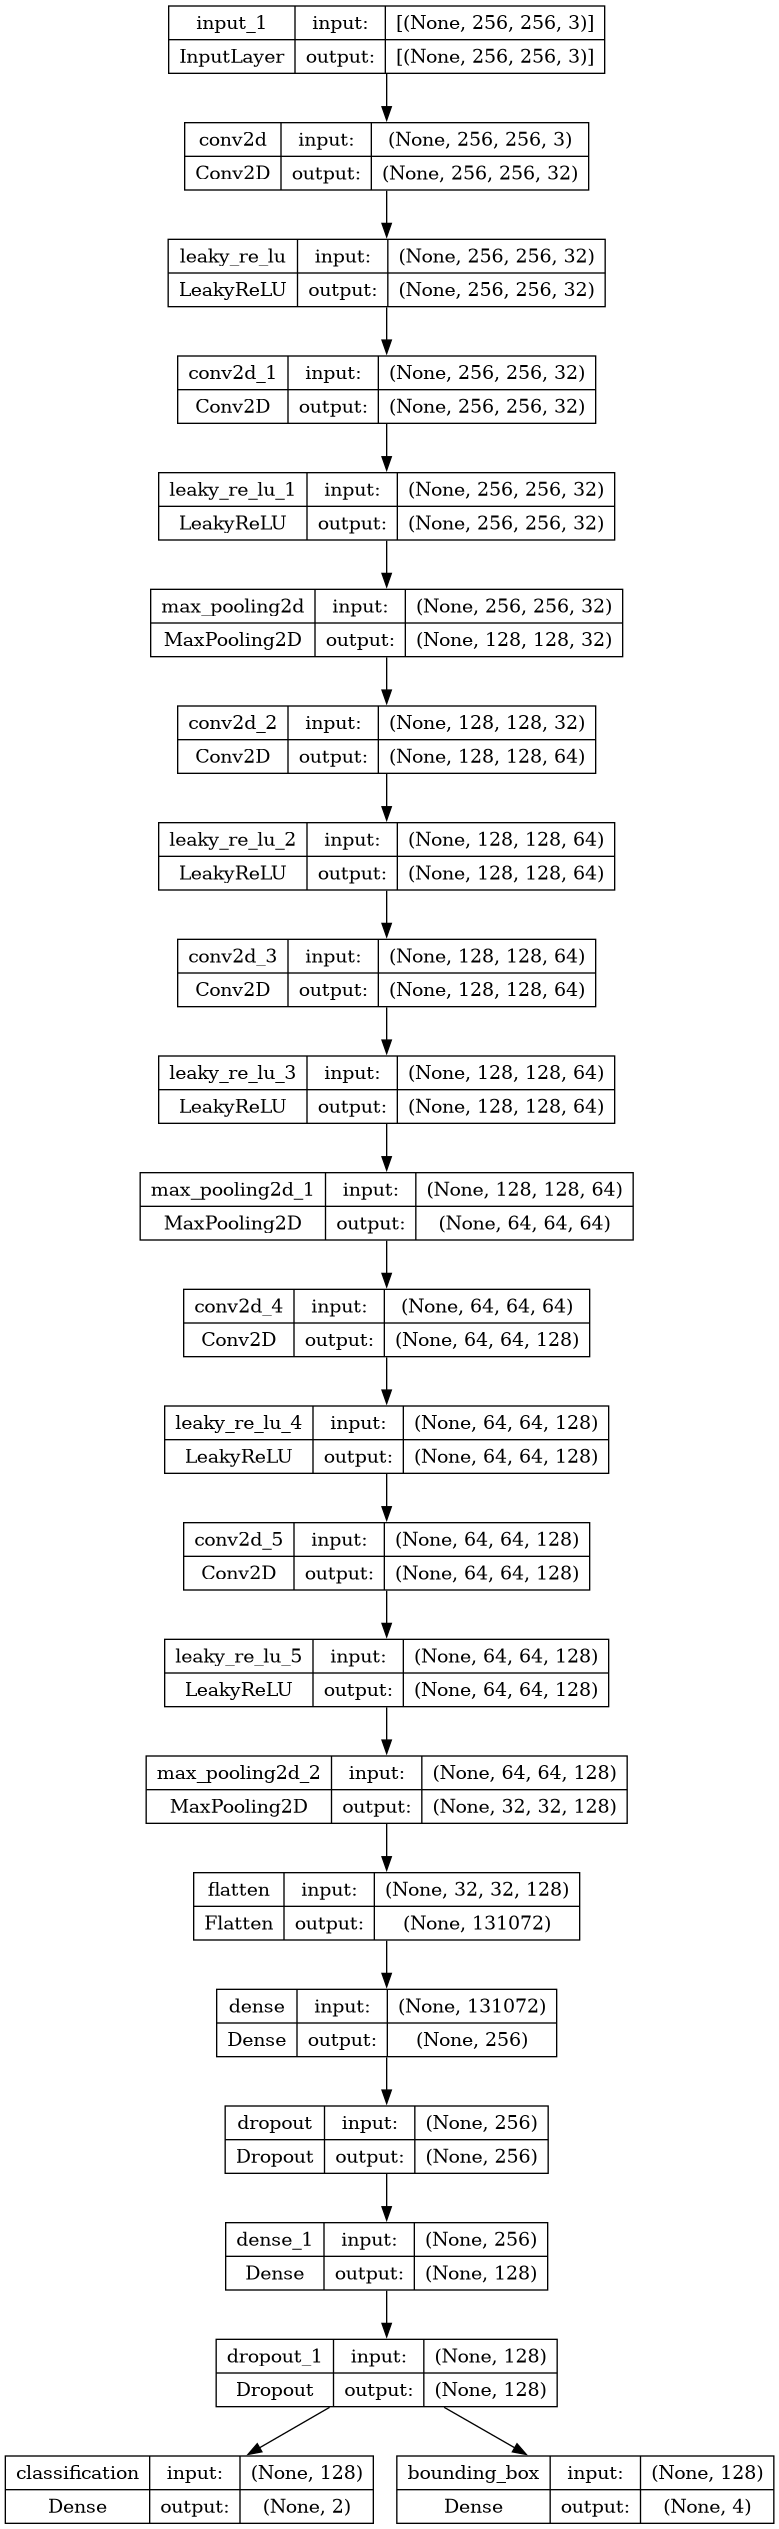

In [35]:
from keras.utils import plot_model
plot_model(model, to_file='/kaggle/working/model_plot.png', show_shapes=True, show_layer_names=True)

# Train model

In [41]:
history = model.fit(images_train, {'classification': labels_train, 'bounding_box': bbox_train},
          validation_data=(images_test, {'classification': labels_test, 'bounding_box': bbox_test}),
          epochs=50, batch_size=32)

Epoch 1/50
28/28 [==============================] - 9s 210ms/step - loss: 816.1633 - classification_loss: 10.7484 - bounding_box_loss: 805.4150 - classification_accuracy: 0.5171 - val_loss: 4.5858 - val_classification_loss: 2.3867 - val_bounding_box_loss: 2.1991 - val_classification_accuracy: 0.3453
Epoch 2/50
28/28 [==============================] - 5s 196ms/step - loss: 15.8096 - classification_loss: 2.2509 - bounding_box_loss: 13.5587 - classification_accuracy: 0.5194 - val_loss: 1.2359 - val_classification_loss: 0.9848 - val_bounding_box_loss: 0.2511 - val_classification_accuracy: 0.3184
Epoch 3/50
28/28 [==============================] - 5s 196ms/step - loss: 5.2959 - classification_loss: 1.4033 - bounding_box_loss: 3.8927 - classification_accuracy: 0.4909 - val_loss: 1.0846 - val_classification_loss: 0.8655 - val_bounding_box_loss: 0.2191 - val_classification_accuracy: 0.2915
Epoch 4/50
28/28 [==============================] - 5s 196ms/step - loss: 3.6261 - classification_loss: 1

# Vẽ biểu đồ đánh giá model

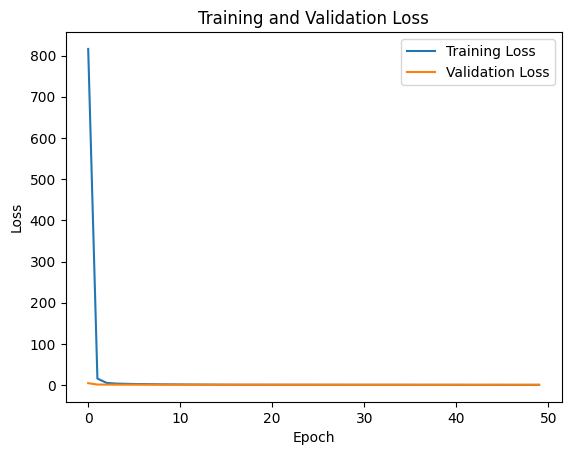

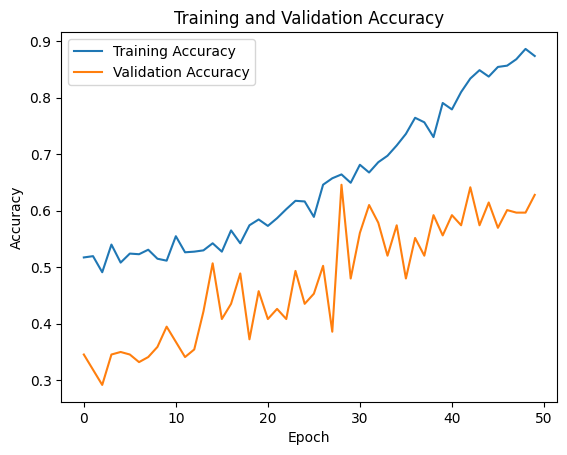

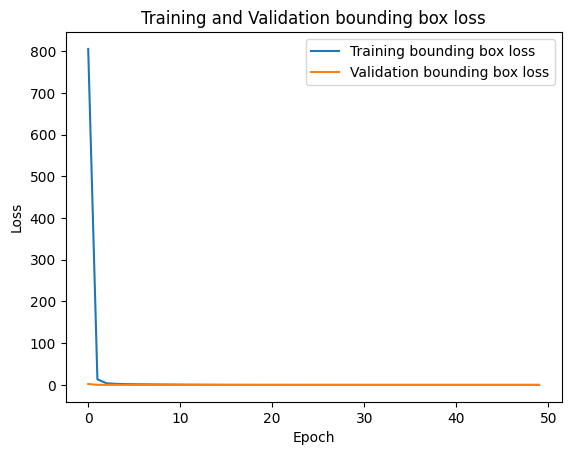

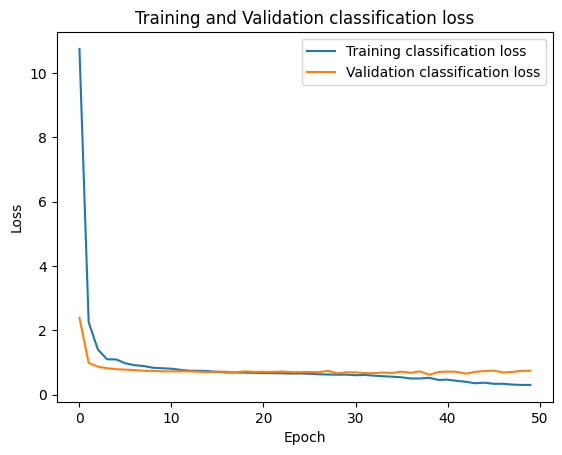

In [50]:
loss = history.history['loss']
classification_loss = history.history['classification_loss']
bounding_box_loss = history.history['bounding_box_loss']
accuracy = history.history['classification_accuracy']
val_loss = history.history['val_loss']
val_classification_loss = history.history['val_classification_loss']
val_bounding_box_loss = history.history['val_bounding_box_loss']
val_accuracy = history.history['val_classification_accuracy']

# Vẽ đồ thị loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Vẽ đồ thị accuracy
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Vẽ đồ thị loss bounding box
plt.plot(bounding_box_loss, label='Training bounding box loss')
plt.plot(val_bounding_box_loss, label='Validation bounding box loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation bounding box loss')
plt.legend()
plt.show()

# Vẽ đồ thị classification loss
plt.plot(classification_loss, label='Training classification loss')
plt.plot(val_classification_loss, label='Validation classification loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation classification loss')
plt.legend()
plt.show()

# Kiểm tra model trên tập test

In [43]:
# 3. Đánh giá mô hình trên dữ liệu test
test_loss= model.evaluate(images_test, {'classification': labels_test, 'bounding_box': bbox_test})

# In kết quả
print("Tổng Loss trên tập dữ liệu kiểm tra:", test_loss[0])
print("Loss cho phân loại:", test_loss[1])
print("Loss cho dự đoán vị trí của bounding box:", test_loss[2])
print("Accuracy cho phân loại:", test_loss[3])

7/7 [==============================] - 0s 62ms/step - loss: 0.7530 - classification_loss: 0.7383 - bounding_box_loss: 0.0147 - classification_accuracy: 0.6278
Tổng Loss trên tập dữ liệu kiểm tra: 0.7529670596122742
Loss cho phân loại: 0.7383162379264832
Loss cho dự đoán vị trí của bounding box: 0.014650780707597733
Accuracy cho phân loại: 0.6278026700019836


# Hiển thị dự đoán của model và nhận xét

1/1 [==============================] - 1s 1s/step
88 52 128 73
81 119 127 173
85 121 141 180
60 49 79 59
76 82 121 101


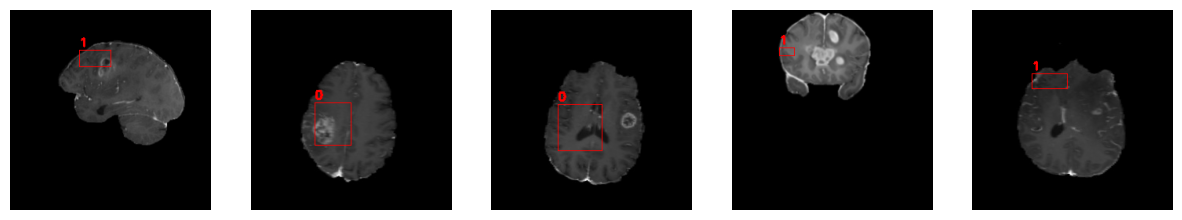

In [44]:
num_images_to_predict = 5
predicted_results = model.predict(images_test[:num_images_to_predict])

# Tạo một danh sách để lưu trữ các ảnh đã vẽ bounding box
images_with_bbox = []
class_labels = [0, 1]
# Duyệt qua từng ảnh và vẽ bounding box dự đoán lên ảnh
for i in range(num_images_to_predict):
    # Lấy ảnh từ tập dữ liệu test
    img = images_test[i]
    
    # Dự đoán phân loại và bounding box cho ảnh
    classification_pred = np.argmax(predicted_results[0][i])
    bbox_pred = predicted_results[1][i]
    
    # Tính toạ độ của bounding box trong ảnh
    x, y, w, h = float(bbox_pred[0]), float(bbox_pred[1]), float(bbox_pred[2]), float(bbox_pred[3])
    x_pt1 = int((x - w/2) * img.shape[1])
    y_pt1 = int((y - h/2) * img.shape[0])
    x_pt2 = int((x + w/2) * img.shape[1])
    y_pt2 = int((y + h/2) * img.shape[0])
    
    predicted_label = class_labels[classification_pred]
    
    print(x_pt1, y_pt1, x_pt2, y_pt2)
    
    # Vẽ bounding box lên ảnh
    cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), (255, 0, 0), 1)
    cv2.putText(img, str(predicted_label), (x_pt1, y_pt1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    # Thêm ảnh đã vẽ bounding box vào danh sách
    images_with_bbox.append(img)

# Hiển thị các ảnh đã vẽ bounding box
fig, axes = plt.subplots(1, num_images_to_predict, figsize=(15, 5))
for i in range(num_images_to_predict):
    axes[i].imshow(images_with_bbox[i])
    axes[i].axis('off')
plt.show()

112 60 129 85
79 137 107 172
164 131 185 151
99 47 130 73
153 124 166 136


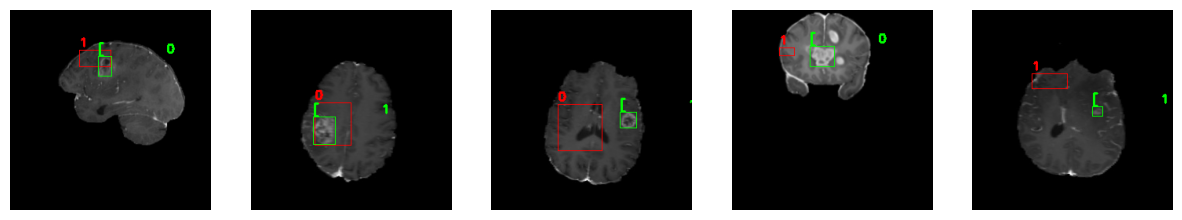

In [49]:
images_test_true = []
for i in range(num_images_to_predict):
    # Lấy ảnh từ tập dữ liệu test
    img = images_test[i]
    bbox = bbox_test[i]
    label = labels_test[i]
    
    # Tính toạ độ của bounding box trong ảnh
    x, y, w, h = float(bbox[0]), float(bbox[1]), float(bbox[2]), float(bbox[3])
    x_pt1 = int((x - w/2) * img.shape[1])
    y_pt1 = int((y - h/2) * img.shape[0])
    x_pt2 = int((x + w/2) * img.shape[1])
    y_pt2 = int((y + h/2) * img.shape[0])
    
    print(x_pt1, y_pt1, x_pt2, y_pt2)
    
    # Vẽ bounding box lên ảnh
    cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), (0, 255, 0), 1)
    cv2.putText(img, str(label), (x_pt1, y_pt1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    # Thêm ảnh đã vẽ bounding box vào danh sách
    images_test_true.append(img)

# Hiển thị các ảnh đã vẽ bounding box
num_images_to_predict = 5
fig, axes = plt.subplots(1, num_images_to_predict, figsize=(15, 5))
for i in range(num_images_to_predict):
    axes[i].imshow(images_with_bbox[i])
    axes[i].axis('off')
plt.show()

In [47]:
model.save("/kaggle/working/rcnn.h5")

# Đánh giá

Sau khi train với mô hình R-CNN qua 50 epochs

- Classification_accuracy: 62.78%
- Tổng Loss trên tập dữ liệu kiểm tra: 75.296%
- Loss cho phân loại: 0.7383162379264832
- Loss cho dự đoán vị trí của bounding box: 0.014650780707597733
- Accuracy cho phân loại: 62.78%

# Hạn chế
- Số lượng dữ liệu không nhiều và đa dạng.

# Kết luận

- Dự đoán còn thiếu chính xác, số lần đào tạo còn ít chỉ mới 50 epochs, cần đào tạo thêm và tinh chỉnh để cho ra kết quả tốt hơn.
- Mô hình có dấu hiệu bị overfit.
